# Working with Filters

In synthesizer we encapsulate all filter based functionality in two objects: 

- A `Filter`: Individual filters with methods and attributes to work with a filters wavelength coverage and transmission.

- A `FilterCollection`: A collection of `Filter`s that behaves like a list with extra attributes and methods to efficiently work with multiple `Filter`s.

We provide a number of different ways to define a `Filter` or set of `Filter`s:

- Generic: A generic filter simply requires a user defined wavelength array and transmission curve to initialise. As such a user can define any arbitrary filter they like using this functionality. 

- Top Hat: A top hat filter's transmission is 1 in a particular range and 0 everywhere else. These are either defined by a minimum and maximum wavelength of transmission or by the effective wavelength of the transmission and its FWHM.

- SVO: We also provide an interface to the SVO filter service (http://svo2.cab.inta-csic.es/theory/fps/). The user need only provide the filter code in "Observatory/Instrument.code" format (as shown on SVO) to extract the relevant information from this service and create a `Filter` object.

In [1]:
import numpy as np
from synthesizer.filters import Filter, FilterCollection
from synthesizer.exceptions import WavelengthOutOfRange, InconsistentWavelengths

## Defining a wavelength array

Here we define some wavelengths (in Angstrom) over which we want to define our filters. We can pass this wavelength array to the `Filter` at initialisation and the `Filter`'s tranmission curve will be defined on the passed wavelength array. In practice we would normally use the wavelength array on the `Grid` object to avoid confusion between wavelength arrays on different objects but here we will ignore this. 

Additionally, it is not required, but it is recommended to initialise a `Filter`/`FilterCollection` with a rest frame wavelength grid (i.e. the `Grid` wavelength array). Although nothing will break if you use an observer frame wavelength grid, the code expects rest frame wavelengths to ensure `*.lam` arrays agree across Synthesizer objects. Any redshifting of `Filter` transmission curves is then handled automatically with minimal overhead. 

One exception to this rule is when calculating photometry for a large number of objects all at a specific redshift. In that case it is more efficient to use an observer frame wavelength grid on a `Filter`/`FilterCollection` and simply be aware that `Filter.lam` differs from `Grid.lam` and `SED.lam`.

In [2]:
lams = np.linspace(2000, 55000, 1000)

## Creating different types of Filter

To define a generic `Filter` we need to define some arbitray transmission curve that maps onto our wavelength array.

In [3]:
trans = np.zeros(lams.size)
trans[int(lams.size / 4) : int(lams.size / 2)] = 1
filt = Filter("generic/filter.1", transmission=trans, new_lam=lams)

To define a Top Hat `Filter` we need can define either the minimum and maximum wavelength of the transmission...

In [4]:
filt1 = Filter("top_hat/filter.1", lam_min=3000, lam_max=5500, new_lam=lams)

or the effective wavelength of the transmission and its FWHM.

In [5]:
filt2 = Filter("top_hat/filter.2", lam_eff=7000, lam_fwhm=2000, new_lam=lams)

To create a `Filter` from the SVO database we simply pass the corresponding SVO filter identifier when intialising the `Filter`.

In [6]:
filt3 = Filter("JWST/NIRCam.F444W", new_lam=lams)

## Creating a FilterCollection

We can intitialise a `FilterCollection` for each different type of `Filter` in a very similar way to what is shown above. However, now the inputs are ensembles of filter properties. You may have noticed in the above examples that each `Filter` was intialised with a string identifier regardless of whether it was an SVO filter or not. These are the `Filter`'s "filter code". These are used to identify each filter and act as a `Filter`'s key in dictionaries when required.

For a set of generic filters we must provide a dictionary of transmission curves where the key is the `Filter`'s filter code.

In [7]:
generics = {"generic_filter1": trans, "generic_filter2": trans}
generic_filters = FilterCollection(generic_dict=generics, new_lam=lams)

For a set of top hat filters we must pass a dictionary containing the properties of each `Filter` where the keys are the `Filter`'s filter code.

In [8]:
tophats = {
    "top_hat1": {"lam_eff": 25000, "lam_fwhm": 8000},
    "top_hat12": {"lam_min": 15000, "lam_max": 30000},
}
top_hat_filters = FilterCollection(tophat_dict=tophats, new_lam=lams)

For a set of SVO filters we must pass a list of filter codes to be extracted from the database.

In [9]:
filter_codes = [f"JWST/NIRCam.{f}" for f in ["F070W", "F444W"]]
svo_filters = FilterCollection(filter_codes=filter_codes, new_lam=lams)

You can also pass a list of existing `Filter`s.

In [10]:
filt_lst = [filt1, filt2, filt3]
filt_filters = FilterCollection(filters=filt_lst, new_lam=lams)

However, you are not tied to having a single type of `Filter` in a `FilterCollection`, they can be mixed and matched at will by passing in each ensemble of properties.

In [11]:
fs = [f"JWST/NIRCam.{f}" for f in ["F090W", "F250M"]]
tophats = {
    "U": {"lam_eff": 3650, "lam_fwhm": 660},
    "V": {"lam_eff": 5510, "lam_fwhm": 880},
    "J": {"lam_eff": 12200, "lam_fwhm": 2130},
}
generics = {"generic_filter3": trans}
filt_lst = [filt1, filt2]
combined_filters = FilterCollection(
    filter_codes=fs, tophat_dict=tophats, generic_dict=generics, filters=filt_lst, new_lam=lams
)

One important thing to note when creating a `FilterCollection` is that all `Filter`s in a `FilterCollection` will always be interpolated onto a common wavelength array. If a wavelength array has been passed to `new_lam` then all transmission curves will be interpolated on to it, otherwise, a common wavelength array is found including the wavelength arrays of all filters with any gaps filled with values at the minimum mean resolution of all filters. Any overlaping areas will adopt the wavelength array of the higher resolution filter.

## Working with a FilterCollection

`FilterCollection`s behave a bit like Python `list`s and a bit like Python `dict`s. As such you can treat them as you would either of these data structures. Additionally, some helpful Python operators have been overloaded to make working with `FilterCollection`s easier.

You can get their length:

In [12]:
print("We have %d filters" % len(combined_filters))

We have 8 filters


Loop over them:

In [13]:
print("My Filters:")
for f in combined_filters:
    print(f.filter_code)

My Filters:
JWST/NIRCam.F090W
JWST/NIRCam.F250M
U
V
J
generic_filter3
top_hat/filter.1
top_hat/filter.2


Compare FilterCollections:

In [14]:
if combined_filters == combined_filters:
    print("This is the same filter collection!")
if combined_filters != generic_filters:
    print("These are not the same filter collection!")

This is the same filter collection!
These are not the same filter collection!


Extract a specific filter by key:

In [15]:
filt = combined_filters["JWST/NIRCam.F090W"]
print(filt.filter_code)

JWST/NIRCam.F090W


And add `Filter`s and `FilterCollection`s:

In [16]:
new_filters = combined_filters + top_hat_filters
new_filters += generic_filters
print("My combined Filters:", new_filters.filter_codes)

My combined Filters: ['JWST/NIRCam.F090W', 'JWST/NIRCam.F250M', 'U', 'V', 'J', 'generic_filter3', 'top_hat/filter.1', 'top_hat/filter.2', 'top_hat1', 'top_hat12', 'generic_filter1', 'generic_filter2']


Note that adding `Filter`s or `FilterCollection`s to a `FilterCollection` will result in interpolation of the transmission curves onto the `FilterCollection`'s wavelength array. In the event the wavelength arrays differ, the wavelengths of the `FilterCollection` being added to are maintained and a warning is printed if this will truncate the transmission curve of the `Filter` being added. If the truncation results in 0 transmission then an error is raised.

In [17]:
filter_codes = [f"JWST/NIRCam.{f}" for f in ["F070W", "F444W"]]
new_filters2 = FilterCollection(filter_codes=filter_codes)
out_of_range_filt = Filter("JWST/MIRI.F2550W")

try:
    new_filters2 = new_filters2 + out_of_range_filt 
except InconsistentWavelengths as e:
    print("InconsistentWavelengths:", e)

Calculated wavelength array: 
min = 6.03e+03 Angstrom
max = 5.10e+04 Angstrom
FilterCollection.lam.size = 26851
InconsistentWavelengths: Interpolated transmission curve has no non-zero values. Consider removing this filter or extending the wavelength range. 


### Helper methods

We provide a number of helper methods and functions to make certain functionality quick and easy.

You can easily plot the transmission curves.

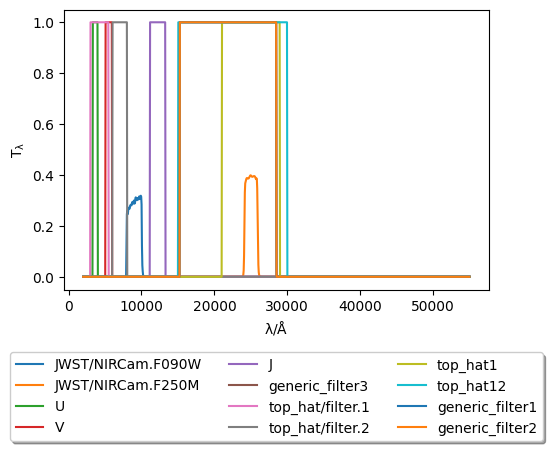

In [18]:
fig, ax = new_filters.plot_transmission_curves(show=True)

You can generate a UVJ top hat `FilterCollection` without defining the properties, we have hardcoded them in an importable function.

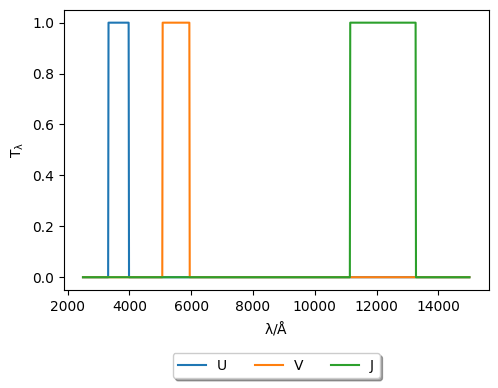

In [19]:
from synthesizer.filters import UVJ

lams = np.linspace(2500, 15000, 1000)
fc = UVJ(new_lam=lams)
fig, ax = fc.plot_transmission_curves(show=True)

Each individual `Filter` has a number of methods to calculate useful filter properties.

In [20]:
print(f"The pivot wavelength of {filt.filter_code} is {filt.pivwv():.2e}.")
print(
    f"The transmission at the pivot wavelength of {filt.filter_code} is {filt.pivT():.2e}."
)
print(f"The mean wavelength of {filt.filter_code} is {filt.meanwv():.2e}.")
print(f"The bandwidth of {filt.filter_code} is {filt.bandw():.2e}.")
print(f"The FWHM of {filt.filter_code} is {filt.fwhm():.2e}.")
print(f"The transmission peak of {filt.filter_code} is {filt.Tpeak():.2e}.")
print(f"The rectangular width of {filt.filter_code} is {filt.rectw():.2e}.")
print(
    f"The maximum wavelength with non-zero transmission of {filt.filter_code} is {filt.max():.2e}."
)
print(
    f"The minimum wavelength with non-zero transmission of {filt.filter_code} is {filt.min():.2e}."
)
min_max = filt.mnmx()
print(
    f"The minimum and maximum wavelength (regardless of transmission) of {filt.filter_code} is {min_max[0]:.2e} and {min_max[1]}:.2e."
)

The pivot wavelength of JWST/NIRCam.F090W is 9.02e+03 Å.
The transmission at the pivot wavelength of JWST/NIRCam.F090W is 2.92e-01.
The mean wavelength of JWST/NIRCam.F090W is 8.98e+03 Å.
The bandwidth of JWST/NIRCam.F090W is 6.11e+02 Å.
The FWHM of JWST/NIRCam.F090W is 1.44e+03 Å.
The transmission peak of JWST/NIRCam.F090W is 3.19e-01.
The rectangular width of JWST/NIRCam.F090W is 1.94e+03.
The maximum wavelength with non-zero transmission of JWST/NIRCam.F090W is 1.02e+04 Å.
The minimum wavelength with non-zero transmission of JWST/NIRCam.F090W is 7.90e+03 Å.
The minimum and maximum wavelength (regardless of transmission) of JWST/NIRCam.F090W is 7.84e+03 Å and 10355.5 Å:.2e.


## Saving and loading FilterCollections

You may encounter situations where you want to save a `FilterCollection`. This can be particularly useful to avoid periods where the SVO database goes down or when using a single `FilterCollection` across a number of MPI ranks where the multiple SVO database calls can cause failures. 

To do this you can simply call the `write_filters` method, passing the path where you want to save the file. This will create a HDF5 file containing the attributes and datasets defining the `FilterCollection`.

In [21]:
# Write out the filter collection to a file in the synthesizer root directory
new_filters.write_filters(path="../../test_filter_collection.hdf5")

Note: this HDF5 file contains the version of Synthesizer used to create it as an attribute (`hdf.attrs["synthesizer_version"]`). A warning will be printed if this differs from the version you are using, just in case future changes break the functionlaity of past `FilterCollections`.

To load a `FilterCollection` at a later data you can simply pass the path of the file into the `FilterCollection` at instantiation.

In [22]:
# Load a FilterCollection from a file
new_new_filters = FilterCollection(path="../../test_filter_collection.hdf5")

# Compare filter objects to show they are the same
new_filters == new_new_filters

True

## Finding a Filter

If you want to know the `Filter` in a `FilterCollection` which will probe a particular wavelength we provide a method to calculate this. This can be done for either the filter which probes the desired wavelength in the rest frame, or by providing a redshift the filter that probes that rest frame wavelength in the observer frame can be found. The method will print the resulting filter code and return the `Filter` itself. 

This function takes a method argument. There are 3 methods implemented for doing this:
- "pivot": Find the filter with the closest pivot wavelength to the desired wavelength (the default).
- "mean": Find the filter with the closest mean wavelength to the desired wavelength.
- "transmission": Find the filter with the maximum transmission at the desired wavelength.

In [23]:
# Define the wavelength we want to know the filter for (in the rest frame, with Angstrom units)
search_lam = 25000

# First lets search in the rest frame with the default pivot method
rest_frame_filter = new_filters.find_filter(search_lam)

# What if we used the other methods?
rest_frame_filter = new_filters.find_filter(search_lam, method="mean")
rest_frame_filter = new_filters.find_filter(search_lam, method="transmission")

# Now lets be more realistic, we have an observation redshift 7 which filter can we use?
search_lam = 1000
obs_filter = new_filters.find_filter(search_lam, redshift=7, method="pivot")

Filter containing rest_frame_lam=2.50e+04 Angstrom: JWST/NIRCam.F250M
Filter containing rest_frame_lam=2.50e+04 Angstrom: JWST/NIRCam.F250M
Filter containing rest_frame_lam=2.50e+04 Angstrom: generic_filter3
Filter containing rest_frame_lam=1.00e+03 Angstrom (with observed wavelength=8.00e+03 Angstrom): top_hat/filter.2


Note that the method will produce an error if the transmission of all `Filter`s in the `FilterCollection` is 0 at the desired wavelength. In certain circumstances `"pivot"` and `"mean"` can fail when the wavelength does fall inside a wide band filter.

In [24]:
search_lam = 2000
try:
    obs_filter = new_filters.find_filter(
        search_lam, redshift=7, method="pivot"
    )
except WavelengthOutOfRange as e:
    print(e)

The wavelength (rest_frame_lam=2.00e+03 Angstrom, observed_lam=1.60e+04 Angstrom) has 0 transmission in the closest Filter (J). Try method='transmission'. 


In [25]:
obs_filter = new_filters.find_filter(
    search_lam, redshift=7, method="transmission"
)

Filter containing rest_frame_lam=2.00e+03 Angstrom (with observed wavelength=1.60e+04 Angstrom): generic_filter3


But in most cases if a filter isn't found the `"transmission"` method will also fail.

In [26]:
try:
    obs_filter = new_filters.find_filter(
        search_lam, redshift=15, method="transmission"
    )
except WavelengthOutOfRange as e:
    print(e)

The wavelength (rest_frame_lam=2.00e+03 Angstrom, observed_lam=3.20e+04 Angstrom) does not fall in any Filters. 
